## Yolov5 detect objects and then using a euristic method

In [1]:
import sys
import torch
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 

sys.path.append("../..")
from utils import util_funcs as uf

# Reload to pick last changes
import importlib
%load_ext autoreload
%autoreload 2

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='../best.pt') #Path to trained weights

In [ ]:
# model.eval()
print(type(model))

## Yolov5 Detect products and empty spaces

In [ ]:
img2pred = "test_273_jpg.rf.f9676164ebff36abe420b5efe9337c8d.jpg"
img = cv2.imread("../data/SKU_2.2K/test/images/" + img2pred)
output = model(img)
output.show(labels=True)

Using cache found in /home/sannicosan/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-20 Python-3.8.10 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1060 with Max-Q Design, 6144MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients
Adding AutoShape... 


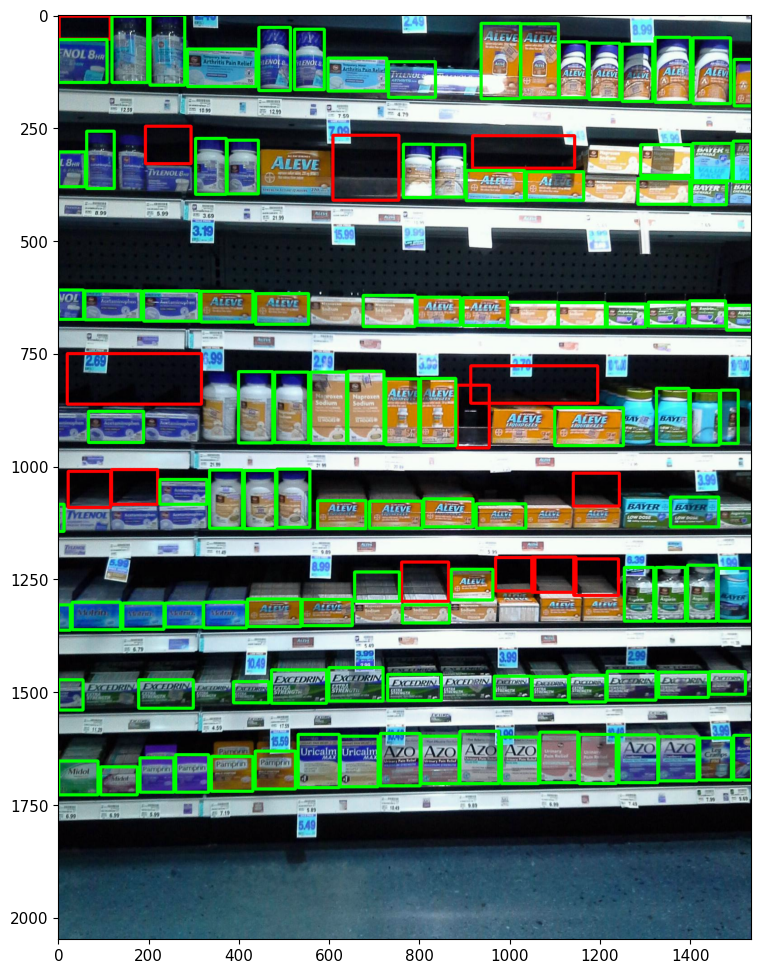

In [3]:
import cv2
import numpy as np
import torch
import pandas as pd


model = torch.hub.load('ultralytics/yolov5', 'custom', path='../best.pt') #Path to trained weights
# model.eval()

# Load images
img_name = os.listdir("../uploads")[-1]
img_path = os.path.join("../uploads",img_name)
img = cv2.imread(img_path)
output = model(img)

df = output.pandas().xyxy[0]
df = df.sort_values("class")
bboxes = df[["xmin","ymin","xmax","ymax","class"]].to_numpy()


#Non Max Supression: best bounding box
def NMS(img_tuple, boxes, overlapThresh = 0.4):
    
    """
    Receives `boxes` as a `numpy.ndarray` and gets the best bounding 
    box when there is overlapping bounding boxes.

    Parameters
    ----------
    boxes : numpy.ndarray
        Array with all the bounding boxes in the image.

    Returns
    -------
    best_bboxes: pd.DataFrame
        Dataframe with only the best bounding boxes, 
        in the format: ["xmin","ymin","xmax","ymax","class"]
    """
    
    #return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # compute the area of the bounding boxes and sort the bounding
    
    # boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We have a least a box of one pixel, therefore the +1
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):

        
        temp_indices = indices[indices!=i]
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        
        if np.any(overlap) > overlapThresh:
            
            if box[4] == 0.0:
                continue                            #[ADDED]: Never delete missing boxxes

            indices = indices[indices != i]
            
    best_bboxes =   boxes[indices].astype(int)
    
    img_name = img_tuple[0]
    img_size = img_tuple[1]
    
    best_bboxes_df = pd.DataFrame(data = best_bboxes, index= [img_name]*len(best_bboxes), columns=["x1","y1","x2","y2","class"])
    best_bboxes_df['total_height'] = img_size[0]
    best_bboxes_df['total_width'] = img_size[1]
    
    return best_bboxes_df

best_bboxes = NMS( (img_name,img.shape),bboxes,0.7)

%matplotlib inline
fig,ax = plt.subplots(figsize = (18,12))
img = uf.bboxes.plot_bboxes(img_path, box_coordinates= best_bboxes, axes = ax )


In [6]:
cv2.imwrite('pred_img.jpg', img)

True

In [10]:
best_bboxes

,x1,y1,x2,y2,class,total_height,total_width
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,685,1070,893,1135,0,2048,1152
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,931,547,1099,662,0,2048,1152
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,715,837,1027,906,0,2048,1152
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,806,1315,901,1433,0,2048,1152
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,708,324,846,415,0,2048,1152
...,...,...,...,...,...,...,...
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,92,617,154,768,1,2048,1152
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,386,835,442,987,1,2048,1152
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,552,1330,622,1439,1,2048,1152
test_106_jpg.rf.35b7fa26b93cabe2c39696bc5b3f0aeb.jpg,304,343,381,511,1,2048,1152
